## What is Pytorch

<img src="pytorch_img.PNG" style="width: 800px;">


<br>
An open source deep learning platform that provides a seamless path from research prototyping to production deployment.

## Why Pytorch

<img src="pytorch_meme.PNG" height="100">

<br>

### HYBRID FRONT-END

A new hybrid front-end provides ease-of-use and flexibility in eager mode, while seamlessly transitioning to graph mode for speed, optimization, and functionality in C++ runtime environments.

### DISTRIBUTED TRAINING

Optimize performance in both research and production by taking advantage of native support for asynchronous execution of collective operations and peer-to-peer communication that is accessible from Python and C++.

### PYTHON-FIRST

PyTorch is not a Python binding into a monolithic C++ framework. It’s built to be deeply integrated into Python so it can be used with popular libraries and packages such as Cython and Numba.

### TOOLS & LIBRARIES

An active community of researchers and developers have built a rich ecosystem of tools and libraries for extending PyTorch and supporting development in areas from computer vision to reinforcement learning.

### NATIVE ONNX SUPPORT

Export models in the standard ONNX (Open Neural Network Exchange) format for direct access to ONNX-compatible platforms, runtimes, visualizers, and more.

## Simple Image Classification

### Importing Libraries

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import torchvision
import os
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import accuracy_score

In [2]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [3]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [4]:
root_folder = './Data/cifar10'

### Data Loading

In [20]:
img_size = 32
n_channels = 3
n_batches = 12

# Defining transforms to apply on images

train_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [21]:
# Fetching CIFAR10 datasets from web

train_dataset = datasets.CIFAR10(root = root_folder,
                                train = True,
                                transform = train_transforms,
                                target_transform = None,
                                download = True)
test_dataset = datasets.CIFAR10(root = root_folder,
                               train = False,
                               transform = train_transforms,
                               target_transform = None,
                               download = True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Loading data into batches

train_dataloader = DataLoader(train_dataset,batch_size = n_batches,
                             shuffle = True, num_workers = 4)
test_dataloader = DataLoader(test_dataset, batch_size = n_batches,
                            shuffle = True, num_workers = 4)

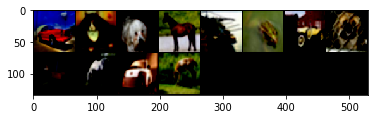

<Figure size 720x720 with 0 Axes>

In [9]:
inputs,labels = next(iter(train_dataloader))

out= torchvision.utils.make_grid(inputs)
imshow(out)

### Linear Classifier

In [97]:
class linear_classifier(nn.Module):
    def __init__(self, img_size, n_channels):
        super(linear_classifier, self).__init__()
        self.fc3 = nn.Linear(img_size * img_size * n_channels, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 124)
        self.fc6 = nn.Linear(124, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return x


lin_class = linear_classifier(img_size, n_channels)

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lin_class.parameters(), lr = 0.001, momentum = 0.9)

In [99]:
n_epochs = 2

t = tqdm.tqdm_notebook(range(n_epochs))
k = tqdm.tqdm_notebook(train_dataloader)

for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for data in k:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
#         optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lin_class(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        k.set_description('Loss: %.3f' %loss)

    t.set_description('Avg. Loss: %.3f' %(running_loss/len(train_dataloader)))

print('Finished Training')

Finished Training


In [100]:
acc_score = 0
for i,data in enumerate(test_dataloader, 0):
    inputs, labels= data
    
    outputs = lin_class(inputs)
#     print('',labels.detach().numpy(),'\n',np.argmax(outputs.detach().numpy(),axis = 1))
    acc_score = acc_score + accuracy_score(labels.detach().numpy(), np.argmax(outputs.detach().numpy(),axis = 1))
    if i == 10:
        break
    
    
print('\n',acc_score/10)


 0.09999999999999999


### Convolution Classifier

<img src="convolution_network_img.PNG" style="width: 1000px; height: 300px;">

In [94]:
class classifier(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 avg_pool_size=2,
                 stride=1):
        
        super(classifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(out_channels, out_channels * 2, kernel_size)
        self.conv3 = nn.Conv2d(out_channels * 2, out_channels * 3, kernel_size)
        self.avgpool = nn.AvgPool2d(avg_pool_size)
        self.fc1 = nn.Linear(out_channels * 3 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 72)
        self.fc3 = nn.Linear(72, 10)

        
    def forward(self, x):
        x = self.conv1(x)
        x= self.avgpool(F.relu(x))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


dis_class = classifier(in_channels=3,
                       out_channels=32,
                       kernel_size=3,
                       avg_pool_size=2,
                       stride=1)


In [95]:
criterion_conv = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(dis_class.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
n_epochs = 2
t = tqdm.tqdm_notebook(range(n_epochs))
k = tqdm.tqdm_notebook(train_dataloader)

for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for data in k:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer_conv.zero_grad()

        # forward + backward + optimize
        outputs = dis_class(inputs)
        loss = criterion_conv(outputs, labels)
        loss.backward()
        optimizer_conv.step()

        # print statistics
        running_loss += loss.item()
        k.set_description('Loss: %.3f' %loss)
        
    t.set_description('Avg. Loss: %.3f' %(running_loss/len(train_dataloader)))

print('Finished Training')

In [ ]:
for i,data in enumerate(test_dataloader, 0):
    inputs, labels= data
    
    outputs = dis_class(inputs)
    print('',labels.detach().numpy(),'\n',np.argmax(outputs.detach().numpy(),axis = 1))
    break

print('\n',accuracy_score(labels.detach().numpy(), np.argmax(outputs.detach().numpy(),axis = 1)))

### Generalizing Convolution Network

In [33]:
class classifier_gen(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 avg_pool_size=2,
                 stride=1, drpout = 0.25):
        
        super(classifier_gen, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(out_channels, out_channels * 2, kernel_size)
        self.conv3 = nn.Conv2d(out_channels * 2, out_channels * 3, kernel_size)
        self.avgpool = nn.AvgPool2d(avg_pool_size)
        self.dropout = nn.Dropout2d(drpout)
        self.fc1 = nn.Linear(out_channels * 3 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 72)
        self.fc3 = nn.Linear(72, 10)

    def forward(self, x):
        #         print(x.size())
        x = self.avgpool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        #         print(x.size())
        x = self.avgpool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        #         print(x.size())
        x = self.avgpool(F.relu(self.conv3(x)))
#         print(x.size())
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


dis_class_gen = classifier_gen(in_channels=3,
                       out_channels=32,
                       kernel_size=3,
                       avg_pool_size=2,
                       stride=1, drpout = 0.25)

In [34]:
criterion_conv_gen = nn.CrossEntropyLoss()
optimizer_conv_gen = optim.SGD(dis_class_gen.parameters(), lr = 0.001, momentum = 0.9)

In [35]:
n_epochs = 2
t = tqdm.tqdm_notebook(range(n_epochs))
k = tqdm.tqdm_notebook(train_dataloader)

for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for data in k:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer_conv_gen.zero_grad()

        # forward + backward + optimize
        outputs = dis_class_gen(inputs)
        loss = criterion_conv_gen(outputs, labels)
        loss.backward()
        optimizer_conv_gen.step()

        # print statistics
        running_loss += loss.item()
        k.set_description('Loss: %.3f' %loss)
        
    t.set_description('Avg. Loss: %.3f' %(running_loss/len(train_dataloader)))

print('Finished Training')

Finished Training


In [ ]:
acc_score = 0
for i,data in enumerate(test_dataloader, 0):
    inputs, labels= data
    
    outputs = dis_class_gen(inputs)
#     print('',labels.detach().numpy(),'\n',np.argmax(outputs.detach().numpy(),axis = 1))
    acc_score = acc_score + accuracy_score(labels.detach().numpy(), np.argmax(outputs.detach().numpy(),axis = 1))
    if i == 10:
        break
    
print('\n',acc_score/10)

### Transfer Learning (VGG 16)

In [39]:
import torchvision.models as models

vgg16 = models.vgg16_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\as19238/.torch\models\vgg16_bn-6c64b313.pth
553507836it [01:06, 8261524.65it/s] 


In [40]:
print(vgg16.classifier[6].out_features)

for param in vgg16.features.parameters():
    param.require_grad = False
    
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]


features.extend([nn.Linear(num_features, 10)])
vgg16.classifier = nn.Sequential(*features)

1000


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(vgg16.parameters(), lr = 0.001 , momentum = 0.9)

In [ ]:
n_epochs = 2
t = tqdm.tqdm_notebook(range(n_epochs))
k = tqdm.tqdm_notebook(train_dataloader)

for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for data in k:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer_vgg.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

        # print statistics
        running_loss += loss.item()
        k.set_description('Loss: %.3f' %loss)
        
    t.set_description('Avg. Loss: %.3f' %(running_loss/len(train_dataloader)))

print('Finished Training')

In [ ]:
acc_score = 0
for i,data in enumerate(test_dataloader, 0):
    inputs, labels= data
    
    outputs = vgg16(inputs)
    print('',labels.detach().numpy(),'\n',np.argmax(outputs.detach().numpy(),axis = 1))
    acc_score = acc_score + accuracy_score(labels.detach().numpy(), np.argmax(outputs.detach().numpy(),axis = 1))
    if i == 10:
        break
    
print('\n',acc_score/10)

## References

* https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd/
* http://cs231n.github.io/optimization-2/
* https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch